# Library

In [1]:
import sys

sys.path.append("quickstart")
sys.path.append("quickstart/code/learn")
sys.path.append("quickstart/code/preprocess")


In [2]:
import torch
import numpy as np


In [3]:
import my_utils
from datasets.building_corners_full import collate_fn_seq


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
['/opt/conda/envs/bim/lib/python38.zip', '/opt/conda/envs/bim/lib/python3.8', '/opt/conda/envs/bim/lib/python3.8/lib-dynload', '', '/opt/conda/envs/bim/lib/python3.8/site-packages', '/opt/conda/envs/bim/lib/python3.8/site-packages/MultiScaleDeformableAttention-1.0-py3.8-linux-x86_64.egg', '/opt/conda/envs/bim/lib/python3.8/site-packages/setuptools/_vendor', 'quickstart', 'quickstart/code/learn', 'quickstart/code/preprocess', '../preprocess']


In [4]:
from quickstart.code.learn.density_full import (
    get_density_slices,
    stack_density_slices,
    padding_density_full,
)


# density_full

In [5]:
floor_idx = 11
data_path = "quickstart/data"
floor_name = "32_ShortOffice_05_F2"
floor_name = "S_01_0001_1_I"


In [11]:
density_slices = get_density_slices(data_path, floor_name)
_density_full = stack_density_slices(density_slices)
_density_full = padding_density_full(_density_full)

if floor_name == "32_ShortOffice_05_F2":
    assert _density_full.shape == (1462, 1462, 3)
elif floor_name == "S_01_0001_1_I":
    assert _density_full.shape == (1462, 1462, 3)
    # assert _density_full.shape == (256, 256, 3)


# norm_scale

In [13]:
# corners = np.load("corners.npy")
corners = np.load(f"quickstart/data/pred_corners/{floor_name}.npy")
image = _density_full.copy()
image, _corners, norm_scale = my_utils.normalize_floor(image, corners)


# edge_model

In [14]:
import time
from quickstart.code.learn.models.unet import ResNetBackbone
from quickstart.code.learn.models.edge_full_models import EdgeEnum


In [15]:
# edge model hyperparameters
deform_type = "DETR_dense"
num_samples = 16
pool_type = "max"
edge_model_path = "ckpts/edge_sample_16"
ckpt_path = "quickstart/ckpts/edge_sample_16/11/checkpoint.pth"


def init_edge_models(ckpt_path="", floor_idx=-1):
    backbone = ResNetBackbone()
    strides = backbone.strides
    num_channels = backbone.num_channels
    backbone = backbone.cuda()
    backbone.eval()

    edge_model = EdgeEnum(
        input_dim=128,
        hidden_dim=256,
        num_feature_levels=4,
        backbone_strides=strides,
        backbone_num_channels=num_channels,
        deform_type=deform_type,
        num_samples=num_samples,
        pool_type=pool_type,
    )
    edge_model = edge_model.cuda()
    edge_model.eval()

    if not ckpt_path:
        assert floor_idx > -1
        ckpt_path = f"{edge_model_path}/{floor_idx}/checkpoint.pth"

    ckpt = torch.load(ckpt_path)
    print("Edge ckpt path: %d from %s" % (ckpt["epoch"], ckpt_path))
    backbone.load_state_dict(ckpt["backbone"])
    edge_model.load_state_dict(ckpt["edge_model"])

    return backbone, edge_model


edge_backbone, edge_model = init_edge_models(ckpt_path=ckpt_path, floor_idx=floor_idx)


/opt/conda/envs/bim/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/bim/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Attention: DETR_dense
Attention layer deform type: DETR_dense
Attention layer num samples: 16
Attention layer pool_type: max
Decoder layer deform type: DETR_dense
Decoder layer num samples: 16
Decoder layer pool_type: max


/tmp/ipykernel_200933/1376947523.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path)


Edge ckpt path: 149 from quickstart/ckpts/edge_sample_16/11/checkpoint.pth


# cache_image_feats

In [16]:
def cache_image_feats(corners):
    image = _density_full.copy()  # (1462, 1462, 3)

    image, _corners, scale = my_utils.normalize_floor(image, corners)
    # ~^ (1023, 1023, 3), (105, 2), 0.700
    image = my_utils.process_image(image)  # (3, 1023, 1023)

    data = {"img": image}
    data = collate_fn_seq([data])

    # Extract image features
    with torch.no_grad():
        image = data["img"].cuda()
        image_feats, feat_mask, _ = edge_backbone(image)

    norm_scale = scale
    image_feats: dict = image_feats
    # image_feats['0'].shape  torch.Size([1, 512, 128, 128])
    # image_feats['1'].shape  torch.Size([1, 1024, 64, 64])
    # image_feats['2'].shape  torch.Size([1, 2048, 32, 32])
    feat_mask = feat_mask  # torch.Size([1, 1023, 1023])
    return image_feats, feat_mask


In [17]:
image_feats, feat_mask = cache_image_feats(corners)


# get_pred_coords

In [18]:
def get_pred_coords(pred_corners, branch="relation", threshold=0.5, postprocess=True):
    image = _density_full.copy()
    pred_corners_raw = pred_corners.copy()

    # _, pred_corners, _ = my_utils.normalize_floor(image, pred_corners)
    # image = my_utils.process_image(image)
    pred_corners, _ = my_utils.normalize_corners(pred_corners, norm_scale)

    all_edges = my_utils.all_combinations[len(pred_corners)]
    edge_coords = pred_corners[all_edges].reshape(-1, 4)

    data = {
        "floor_name": floor_name,
        # "img": image,
        "edge_coords": edge_coords,
        "processed_corners_lengths": len(pred_corners),
    }
    data = collate_fn_seq([data])

    edge_coords = data["edge_coords"].cuda()
    edge_mask = data["edge_coords_mask"].cuda()
    blank_labels = torch.full_like(edge_mask, fill_value=2, dtype=torch.long)

    corner_nums = data["processed_corners_lengths"]
    max_candidates = torch.stack([corner_nums.max() * 3] * len(corner_nums), dim=0)

    # network inference
    with torch.no_grad():
        # image = data["img"].cuda()
        # image_feats, feat_mask, _ = edge_backbone(image)

        (
            logits_s1,
            logits_edge_hb,
            logits_edge_rel,
            logits_width_hb,
            logits_width_rel,
            s2_ids,
            s2_edge_mask,
            s2_gt_values,
            ref_dict,
        ) = edge_model(
            image_feats,
            feat_mask,
            edge_coords,
            edge_mask,
            blank_labels,
            corner_nums,
            max_candidates,
            mask_gt=False,
        )

    # my_utils.vis_ref(image, edge_coords, ref_dict, s2_ids)

    if branch == "relation":
        s2_edges = all_edges[s2_ids[0].cpu().numpy()]
        edge_probs = logits_edge_rel.softmax(1)[0, 1, :].cpu().numpy()
        pred_edges = s2_edges[edge_probs >= threshold]
        # edge_preds = logits_edge_rel.argmax(1)[0].cpu().numpy()
        # pred_edges = s2_edges[edge_preds == 1]
        pred_coords = pred_corners_raw[pred_edges].reshape(-1, 4)

        pred_widths = logits_width_rel.argmax(1)[0].cpu().numpy()
        pred_widths = pred_widths[edge_probs >= threshold]
        # pred_widths = pred_widths[edge_preds == 1]

    elif branch == "hybrid":
        s2_edges = all_edges[s2_ids[0].cpu().numpy()]
        edge_probs = logits_edge_hb.softmax(1)[0, 1, :].cpu().numpy()
        pred_edges = s2_edges[edge_probs >= threshold]
        # edge_preds = logits_edge_hb.argmax(1)[0].cpu().numpy()
        # pred_edges = s2_edges[edge_preds == 1]
        pred_coords = pred_corners_raw[pred_edges].reshape(-1, 4)

        pred_widths = logits_width_hb.argmax(1)[0].cpu().numpy()
        pred_widths = pred_widths[edge_probs >= threshold]
        # pred_widths = pred_widths[edge_preds == 1]

    elif branch == "image":
        raise Exception("Nope")
        edge_probs = logits_s1.softmax(1)[0, 1, :].cpu().numpy()
        pred_edges = all_edges[edge_probs >= threshold]
        pred_coords = pred_corners_raw[pred_edges].reshape(-1, 4)

    else:
        raise Exception("Unknown branch")

    # post-processing to:
    # 1. merge overlapping lines
    # 2. snap almost horizontal or vertical lines
    if postprocess:
        pred_coords, pred_widths = my_utils.remove_overlaps(pred_coords, pred_widths)
        # pred_coords = my_utils.merge_edges(pred_coords)
        pred_coords = my_utils.snap_to_axis(pred_coords)

    # visualize prediction
    # color_coords = [["-v", pred_coords]]
    # my_utils.vis_edges(self.density_full, color_coords)
    # my_utils.vis_edges_idx(self.density_full, pred_coords)

    return pred_coords, pred_edges, pred_widths


In [19]:
heat_coords, heat_edges, heat_widths = get_pred_coords(corners)
print(
    f"heat_coords: {heat_coords.shape}, heat_edges: {heat_edges.shape}, heat_widths: {heat_widths.shape}"
)


/opt/conda/envs/bim/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


heat_coords: (8, 4), heat_edges: (8, 2), heat_widths: (8,)


# Visualize

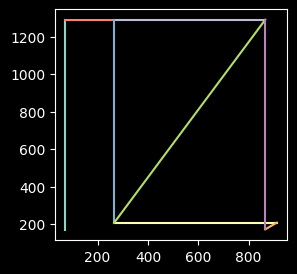

In [20]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(3, 3))
ab_args = heat_coords.reshape(-1, 2, 2).swapaxes(1, 2).reshape(-1, 2)  # (2N,  2)

# segments
ax.plot(*ab_args)

# identify points: a in blue, b in red
plt.show()
